**EE219 Winter 2019, Project 2**

In [16]:
# setting the random seed
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

# Import packages

from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

In [18]:
# Define function that generates the 5 measure scores

def scores(ground, clustered, data=None):
    from sklearn.metrics import homogeneity_score
    from sklearn.metrics import completeness_score
    from sklearn.metrics import v_measure_score
    from sklearn.metrics import adjusted_rand_score
    from sklearn.metrics import adjusted_mutual_info_score
    
    if data is not None:
        homogeneity = data['homogeneity']
        completeness = data['completeness']
        v_measure = data['v']
        adjusted_rand_index = data['rand']
        adjusted_mutual_info = data['mutual_info']
    else:
        homogeneity = homogeneity_score(ground, clustered.labels_)
        completeness = completeness_score(ground, clustered.labels_)
        v_measure = v_measure_score(ground, clustered.labels_)
        adjusted_rand_index = adjusted_rand_score(ground, clustered.labels_)
        adjusted_mutual_info = adjusted_mutual_info_score(ground, clustered.labels_)

    print('kmeans clustering results with k=2')
    print('-------------------------------------------------------------------')
    print('Homegeneity: {}'.format(np.round(homogeneity, 4)))
    print('Completeness: {}'.format(np.round(completeness, 4)))
    print('V-measure: {}'.format(np.round(v_measure, 4)))
    print('Adjusted Rand Index: {}'.format(np.round(adjusted_rand_index, 4)))
    print('Adjusted Mutual Information Score: {}'.format(np.round(adjusted_mutual_info, 4)))
    print('-------------------------------------------------------------------')

##### Function for saving pre-fit SVD and NMF scores, and K-Means objects

In [19]:
def load_scores(npz_name):
    import os
    import os.path as path

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    if os.path.isfile('{}/{}.npz'.format(out_dir, npz_name)):
        data = np.load('{}/{}.npz'.format(out_dir, npz_name))
        return data
    else:
        return None
    
def save_scores(npz_name, data):
    import os
    import os.path as path

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    np.savez('{}/{}'.format(out_dir, npz_name), homogeneity=data['homogeneity'], completeness=data['completeness'],
             v=data['v'], rand=data['rand'], mutual_info=data['mutual_info'])
    
def dump_kmeans(model_name, kmeans):
    import os
    import os.path as path
    from joblib import dump, load

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    dump(kmeans, '{}/{}.joblib'.format(out_dir, model_name))
    
def load_kmeans(model_name):
    import os
    import os.path as path
    from joblib import dump, load

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    if os.path.isfile('{}/{}.joblib'.format(out_dir, model_name)):
        return load('{}/{}.joblib'.format(out_dir, model_name))
    else:
        return None

In [20]:
# Set the global directory to place figs in project:
figs_dir = 'figs'

import os
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)

In [21]:
# Fetching 20NewsGroups dataset

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics', 'comp.sys.mac.hardware', 
              'comp.os.ms-windows.misc', 'rec.autos', 'rec.motorcycles', 
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)


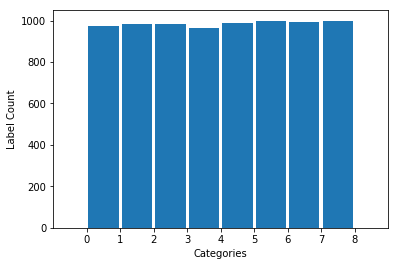

In [22]:
# Fetch all 8 news groups categories and plot a histogram of the training documents.

x = range(-1,23)
plt.hist(twenty_data.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xticks(np.arange(9, step=1))
plt.xlim(left=-1, right = 9)
plt.savefig('{}/8-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

In [23]:
# Change labels into binary based on two well separated classes: Class 1 (labels 0-3) and Class 2 (labels 4-7).
twenty_binary_labels = np.zeros(len(twenty_data.target))
for k in range(len(twenty_data.target)):
    if twenty_data.target[k] >= 4:
        twenty_binary_labels[k] = 1
    else:
        twenty_binary_labels[k] = 0
            
class_names = ['Class 1', 'Class 2']

**Question 1**

In [24]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data = count_vect.fit_transform(twenty_data.data)

In [25]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_data_tfidf = tfidf_transformer.fit_transform(X_data)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf.shape))

Dimensions of the TF-IDF matrix are: (7882, 27768)


**Question 2**

In [26]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans

k_name = 'kmeans_raw8'

kmeans = load_kmeans(k_name)
if kmeans is None:
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1001, n_init = 40).fit(X_data_tfidf)
    dump_kmeans(k_name, kmeans)

**Question 2(a)**

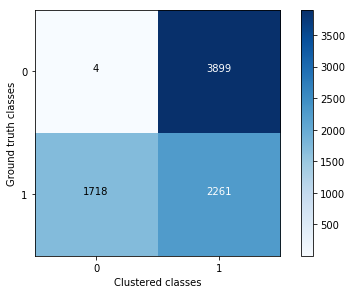

In [27]:
# Contingency matrix
def show_contingency(ground_labels, cluster_labels, title='', cmap=plt.cm.Blues, hide_text=False):
    import itertools
    from sklearn.metrics.cluster import contingency_matrix
    cont = contingency_matrix(ground_labels, cluster_labels)
    
    plt.imshow(cont, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cont.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    
    if not hide_text:
        thresh = (cont.max() - cont.min()) / 2.
        for i, j in itertools.product(range(cont.shape[0]), range(cont.shape[1])):
            plt.text(j, i, format(cont[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cont[i, j] - cont.min() > thresh else "black")
    
    plt.ylabel('Ground truth classes')
    plt.xlabel('Clustered classes')
    plt.show()

show_contingency(twenty_binary_labels, kmeans.labels_, title='')

**Question 2(b)**

In [13]:
scores(twenty_binary_labels, kmeans)

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.2536
Completeness: 0.3348
V-measure: 0.2886
Adjusted Rand Index: 0.1808
Adjusted Mutual Information Score: 0.2535
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


#### Question 4

In [10]:
# Perform SVD on the TF-IDF matrix
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
X_data_svd = svd.fit_transform(X_data_tfidf)

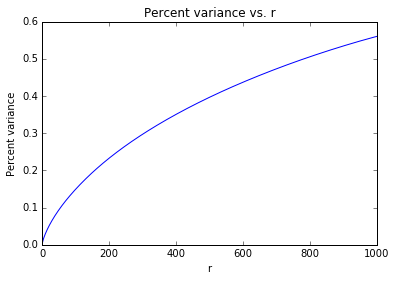

In [11]:
# Plot variance ratios

variances = svd.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(variances))
plt.title('Percent variance vs. r')
plt.xlabel('r')
plt.ylabel('Percent variance')
plt.show()

#### Question 5

In [28]:
# Initialize r, which is basically how many components we want to use.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [29]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

In [30]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

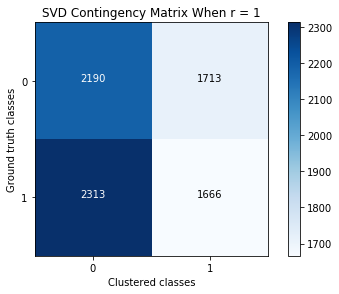

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


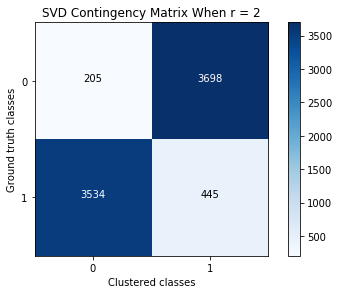

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


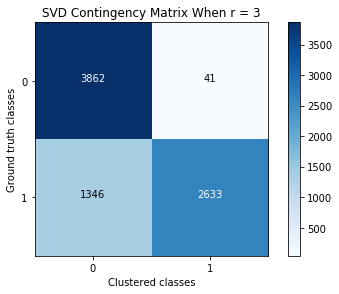

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


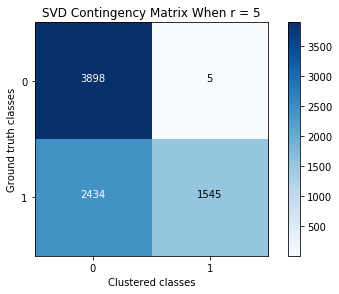

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


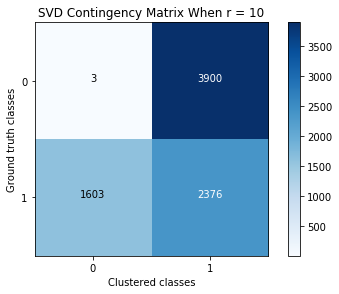

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


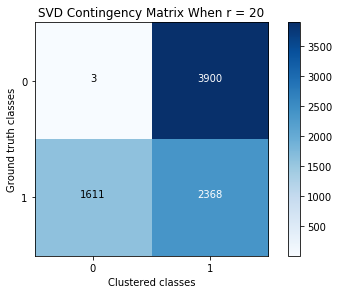

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


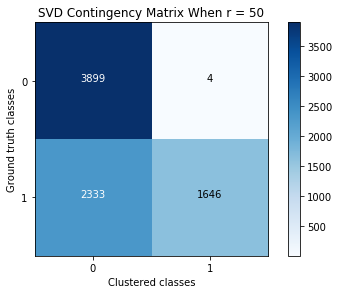

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


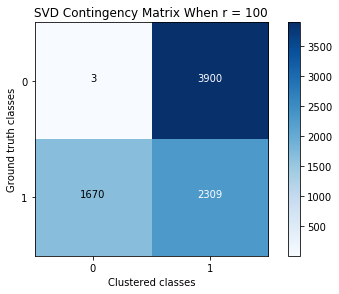

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


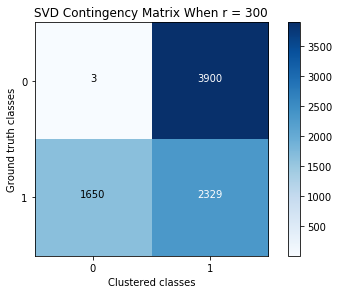

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [31]:
svd_homogeneity = np.zeros(len(r))
svd_completeness = np.zeros(len(r))
svd_v = np.zeros(len(r))
svd_rand = np.zeros(len(r))
svd_mutual_info = np.zeros(len(r))

# svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40)
for i in range(len(r)):
    svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:r[i]].T)
    svd_homogeneity[i] = homogeneity_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(twenty_binary_labels, svd_kmeans.labels_)
    title = 'SVD Contingency Matrix When r = ' + str(r[i])
    show_contingency(twenty_binary_labels, svd_kmeans.labels_, title)
    svd_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, svd_kmeans.labels_)
    

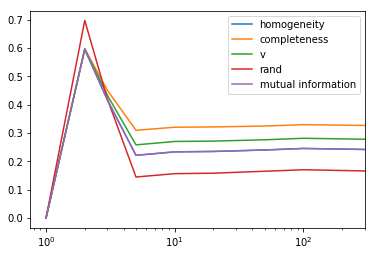

In [32]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.xscale('log')
plt.xlim(right=300)
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [33]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

Homogeneity scores:  [3.000e-04 5.959e-01 4.164e-01 2.217e-01 2.339e-01 2.353e-01 2.405e-01
 2.459e-01 2.423e-01]
Completeness scores:  [3.000e-04 5.970e-01 4.506e-01 3.100e-01 3.207e-01 3.218e-01 3.249e-01
 3.297e-01 3.270e-01]
V measure scores:  [3.000e-04 5.965e-01 4.329e-01 2.585e-01 2.705e-01 2.718e-01 2.765e-01
 2.817e-01 2.784e-01]
Adjusted rand scores:  [3.000e-04 6.973e-01 4.199e-01 1.452e-01 1.570e-01 1.586e-01 1.656e-01
 1.708e-01 1.666e-01]
Adjusted mutual information scores:  [2.000e-04 5.959e-01 4.164e-01 2.216e-01 2.338e-01 2.353e-01 2.405e-01
 2.458e-01 2.422e-01]


In [34]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [35]:
# Initialize r and each an array for each metric.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

nmf_homogeneity = np.zeros(len(r))
nmf_completeness = np.zeros(len(r))
nmf_v = np.zeros(len(r))
nmf_rand = np.zeros(len(r))
nmf_mutual_info = np.zeros(len(r))

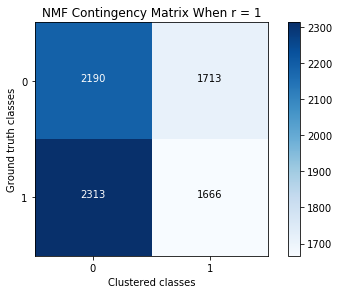

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


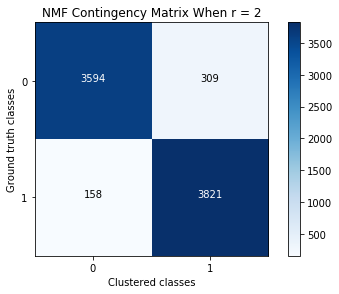

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


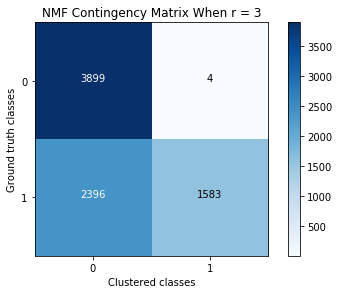

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


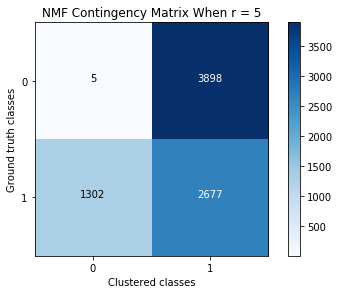

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


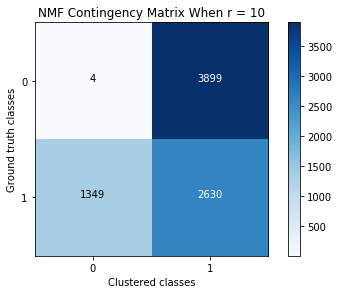

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


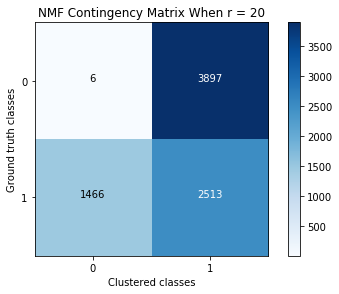

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


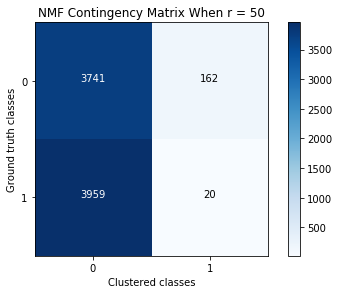

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


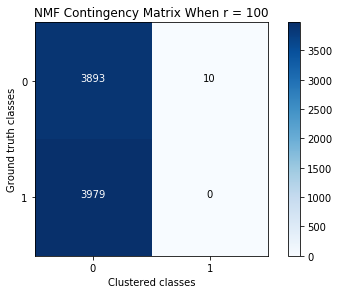

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


KeyboardInterrupt: 

In [36]:
# Perform NMF for each number of components and calculate each metric

for i in range(len(r)):
    nmf = NMF(n_components=r[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf)
    nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(twenty_binary_labels, nmf_kmeans.labels_)
    title = 'NMF Contingency Matrix When r = ' + str(r[i])
    show_contingency(twenty_binary_labels, nmf_kmeans.labels_, title)
    nmf_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, nmf_kmeans.labels_)

In [ ]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.xscale('log')
plt.xlim(right=300)
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [ ]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))

#### Question 6

It is evident that as r moves away from 1, the scores become larger. They rise until a specific point, at which time they change direction and either oscillate or decrease in value. This non-monotonic behavior of the measures as r increases can be explained by a trade-off between the dimension reduction algorithm and K-means algorithm.
   
   By having too few dimensions to represent the data with, the K-means clustering algorithm cannot make accurate clusters around the data. K-means requires there to be enough valuable information about the corpus to cluster with. K-means therefore will improve at the beginning since necessary information is being introduced. However, as more dimensions are added, the K-means clustering algorithm must work with a higher dimensional space. K-means uses Euclidean distances. The Euclidean distance has less affect when in a higher dimensional space. This phenomenon is otherwise known as the curse of dimensionality. This phenomenon causes there to be a general decrease in scores as r increases in value.

#### Question 7

Visualize the clustering results for SVD with best r and NMF with best r

In [55]:
# Visualize clustering results on 2-D plane with SVD and coloring
# Compare ground truth label and clustering label plots

# Define what the best r is for both SVD and NMF
SVD_best_r = 2
NMF_best_r = 2

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)

In [56]:
# Define function that visualizes the results

def visualize(label, axes, title, flip = 1):
    
    # If color needs to be fliped, set flip = 0
    
    if np.array_equal(label, twenty_binary_labels):
        label_for_color = twenty_binary_labels
    else:
        label_for_color = label.labels_
    
    color_for_plotting = np.zeros(len(label_for_color))

    for i in range(len(label_for_color)):
        if label_for_color[i] == flip:
            color_for_plotting[i] = 1
            
    mean0 = np.mean(axes[label_for_color == 0], axis=0)
    mean1 = np.mean(axes[label_for_color != 0], axis=0)
    plt.scatter(axes[:,0] ,axes[:,1], c = color_for_plotting)
    plt.plot(mean0[0], mean0[1], 'x', color='black', mew=3, ms=16)
    plt.plot(mean0[0], mean0[1], 'x', color='white', mew=2, ms=15)
    plt.plot(mean1[0], mean1[1], 'x', color='black', mew=3, ms=16)
    plt.plot(mean1[0], mean1[1], 'x', color='white', mew=2, ms=15)
    plt.title(title)
    plt.show()

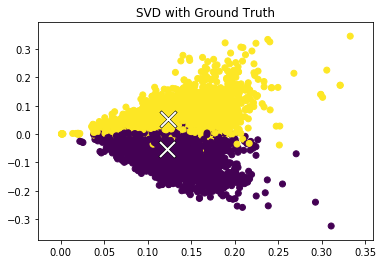

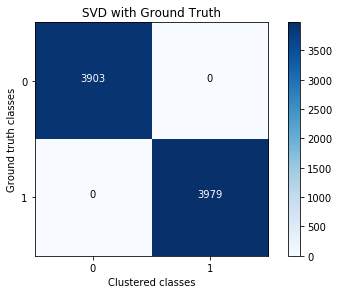

In [57]:
# SVD, ground truth

data_svd_to_plot = X_data_svd_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(twenty_binary_labels, data_svd_to_plot, 'SVD with Ground Truth', 0)

show_contingency(twenty_binary_labels, twenty_binary_labels, 'SVD with Ground Truth')

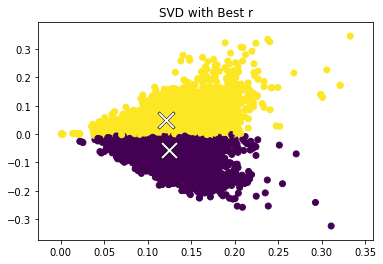

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.5954
Completeness: 0.5965
V-measure: 0.5959
Adjusted Rand Index: 0.6969
Adjusted Mutual Information Score: 0.5954
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


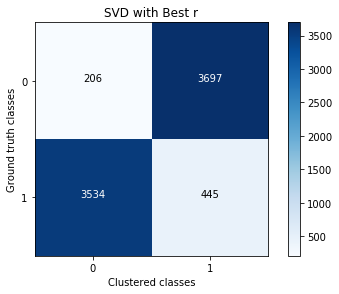

In [76]:
# SVD with best r

svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:SVD_best_r].T)
data_svd_to_plot = X_data_svd_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(svd_kmeans, data_svd_to_plot, 'SVD with Best r',1)

scores(twenty_binary_labels, svd_kmeans)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Best r')

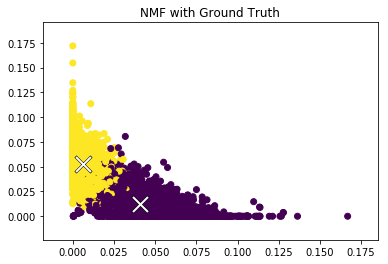

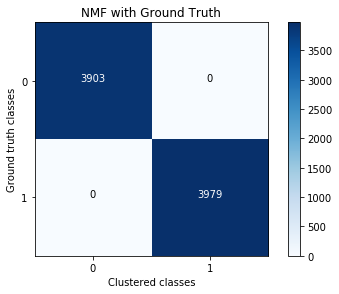

In [59]:
# NMF, ground truth

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

data_nmf_to_plot = X_data_nmf_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(twenty_binary_labels, data_nmf_to_plot, 'NMF with Ground Truth')

show_contingency(twenty_binary_labels, twenty_binary_labels, 'NMF with Ground Truth')

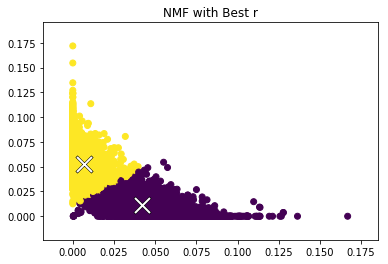

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6786
Completeness: 0.6797
V-measure: 0.6791
Adjusted Rand Index: 0.7766
Adjusted Mutual Information Score: 0.6786
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


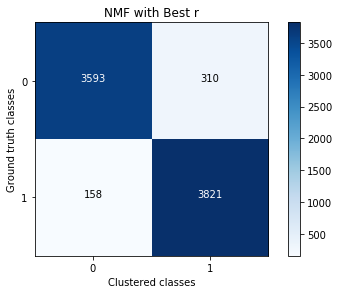

In [60]:
# NMF with best r

# Reset NMF

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    
nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)

data_nmf_to_plot = X_data_nmf_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(nmf_kmeans, data_nmf_to_plot, 'NMF with Best r',1)

scores(twenty_binary_labels, nmf_kmeans)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Best r')

#### Question 8

Transforming the data

In [61]:
# Scaling features such that each feature has unit variance

def scaling (features): # Each column of the reduced dimension data has unit variance 
    return (features - np.mean(features,axis=0)) / np.std(features, axis=0)    

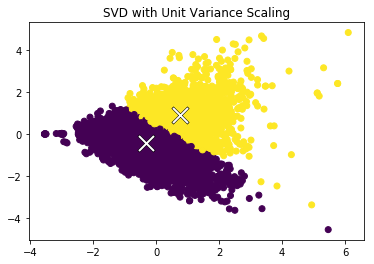

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.2355
Completeness: 0.264
V-measure: 0.2489
Adjusted Rand Index: 0.2549
Adjusted Mutual Information Score: 0.2354
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


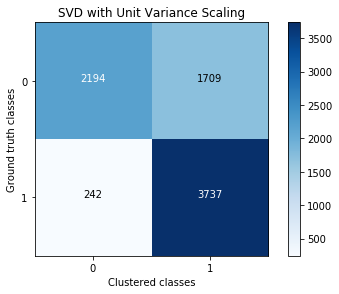

In [62]:
# SVD with Unit Variance Transform

svd_uv_transform = scaling(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_uv_transform.T[0:SVD_best_r].T)

visualize(svd_kmeans, svd_uv_transform, 'SVD with Unit Variance Scaling',0)
scores(twenty_binary_labels, svd_kmeans)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Unit Variance Scaling')

In [63]:
# Logarithm transformation 

def logarithm_trans (features): 
    
    c_const = 0.01
    return np.sign(features) * (np.log(np.abs(features) + c_const) - np.log(c_const))

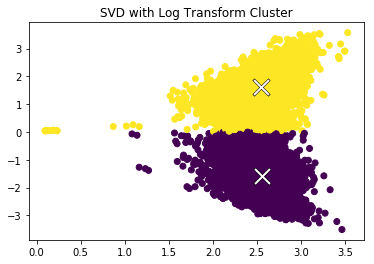

In [64]:
# SVD with Logarithm Transform

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_log_transform = logarithm_trans(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_log_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_log_transform, 'SVD with Log Transform Cluster',1)

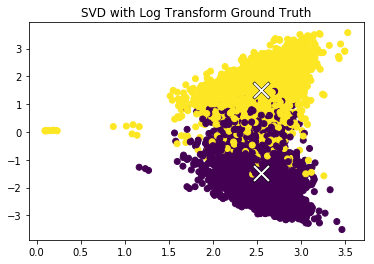

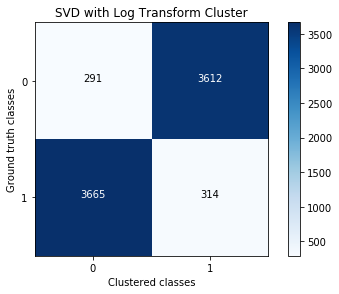

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6094
Completeness: 0.6094
V-measure: 0.6094
Adjusted Rand Index: 0.7165
Adjusted Mutual Information Score: 0.6094
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [65]:
visualize(twenty_binary_labels, svd_log_transform, 'SVD with Log Transform Ground Truth', 0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Log Transform Cluster')

scores(twenty_binary_labels, svd_kmeans)

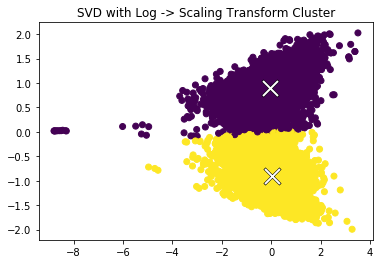

In [66]:
# SVD with Logarithm -> Scaling Transform

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_log_transform = logarithm_trans(X_data_svd_r)

svd_log_scaling_transform = scaling(svd_log_transform)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_log_scaling_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_log_scaling_transform, 'SVD with Log -> Scaling Transform Cluster', 1)

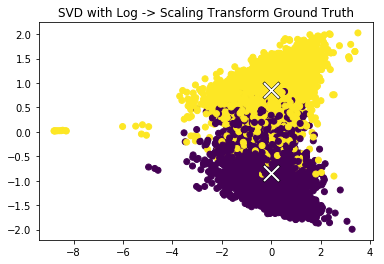

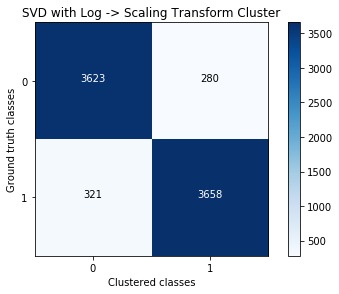

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6114
Completeness: 0.6114
V-measure: 0.6114
Adjusted Rand Index: 0.7182
Adjusted Mutual Information Score: 0.6113
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [67]:
visualize(twenty_binary_labels, svd_log_scaling_transform, 'SVD with Log -> Scaling Transform Ground Truth', 0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Log -> Scaling Transform Cluster')

scores(twenty_binary_labels, svd_kmeans)

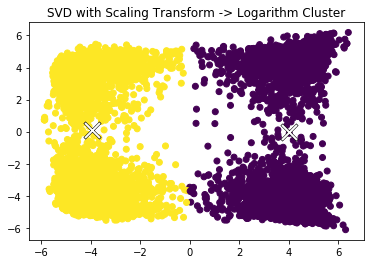

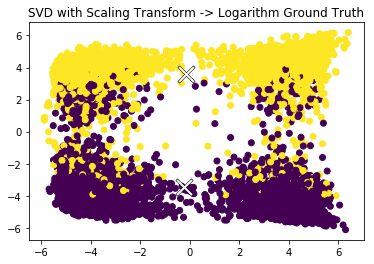

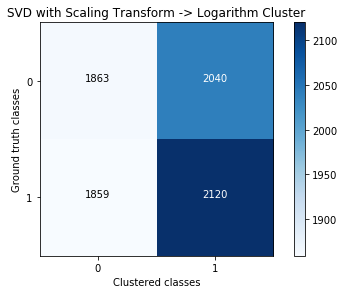

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.0001
Completeness: 0.0001
V-measure: 0.0001
Adjusted Rand Index: -0.0
Adjusted Mutual Information Score: -0.0
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [68]:
# SVD with Scaling Transform -> Logarithm

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_scaling_transform = scaling(X_data_svd_r)

svd_scaling_log_transform = logarithm_trans(svd_scaling_transform)
svd_kmeans = KMeans(n_clusters=2, random_state=100, max_iter=2000, n_init=200).fit(svd_scaling_log_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_scaling_log_transform, 'SVD with Scaling Transform -> Logarithm Cluster')
visualize(twenty_binary_labels, svd_scaling_log_transform, 'SVD with Scaling Transform -> Logarithm Ground Truth',0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Scaling Transform -> Logarithm Cluster')

scores(twenty_binary_labels, svd_kmeans)

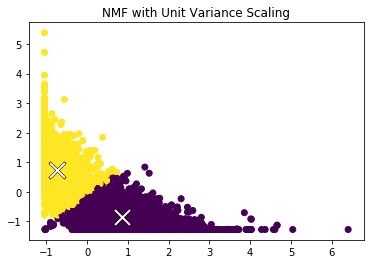

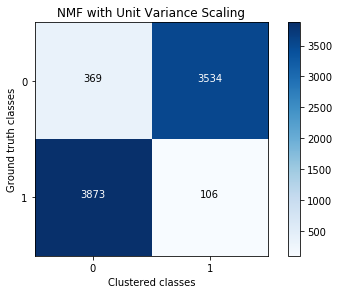

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6828
Completeness: 0.6856
V-measure: 0.6842
Adjusted Rand Index: 0.7734
Adjusted Mutual Information Score: 0.6828
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [69]:
# NMF with Unit Variance Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_uv_transform = scaling(X_data_nmf_r)
nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_uv_transform)

visualize(nmf_kmeans, nmf_uv_transform, 'NMF with Unit Variance Scaling', 0)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Unit Variance Scaling')

scores(twenty_binary_labels, nmf_kmeans)

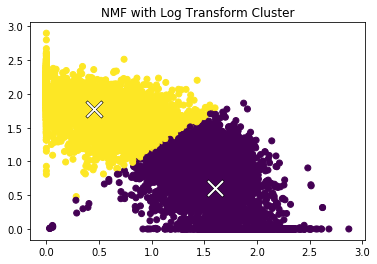

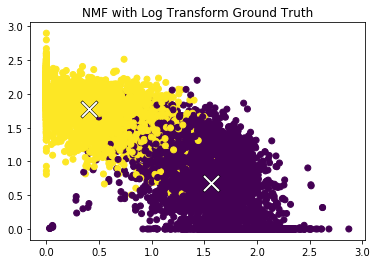

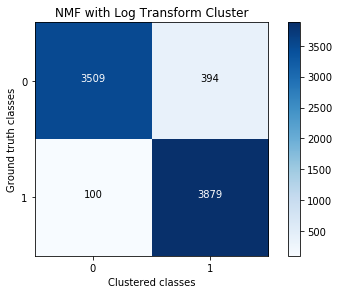

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6757
Completeness: 0.6791
V-measure: 0.6774
Adjusted Rand Index: 0.765
Adjusted Mutual Information Score: 0.6757
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [70]:
# NMF with Logarithm Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_log_transform = logarithm_trans(X_data_nmf_r)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_log_transform)

visualize(nmf_kmeans, nmf_log_transform, 'NMF with Log Transform Cluster', 1)
visualize(twenty_binary_labels, nmf_log_transform, 'NMF with Log Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Log Transform Cluster')

scores(twenty_binary_labels, nmf_kmeans)

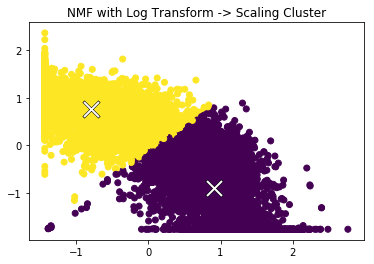

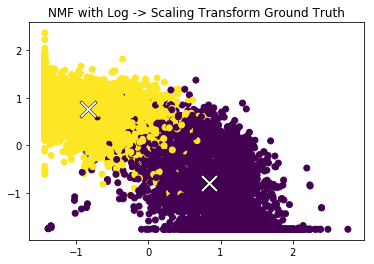

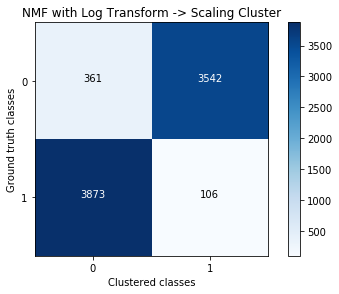

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6864
Completeness: 0.6891
V-measure: 0.6877
Adjusted Rand Index: 0.777
Adjusted Mutual Information Score: 0.6863
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [71]:
# NMF with Logarithm -> Scaling Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_log_transform = logarithm_trans(X_data_nmf_r)
nmf_log_scaling_transform = scaling(nmf_log_transform)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_log_scaling_transform)

visualize(nmf_kmeans, nmf_log_scaling_transform, 'NMF with Log Transform -> Scaling Cluster', 0)
visualize(twenty_binary_labels, nmf_log_scaling_transform, 'NMF with Log -> Scaling Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Log Transform -> Scaling Cluster')

scores(twenty_binary_labels, nmf_kmeans)

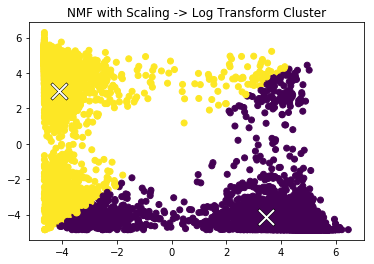

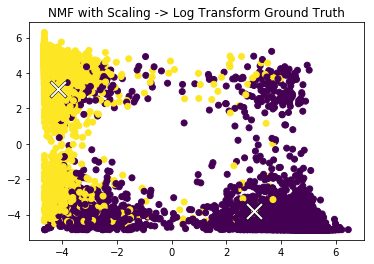

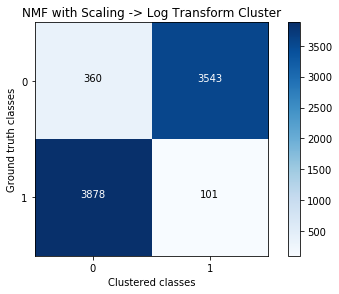

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.69
Completeness: 0.6928
V-measure: 0.6914
Adjusted Rand Index: 0.7797
Adjusted Mutual Information Score: 0.6899
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [72]:
# NMF with Scaling -> Logarithm Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_scaling_transform = scaling(X_data_nmf_r)

nmf_scaling_log_transform = logarithm_trans(nmf_scaling_transform)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_scaling_log_transform)

visualize(nmf_kmeans, nmf_scaling_log_transform, 'NMF with Scaling -> Log Transform Cluster', 0)
visualize(twenty_binary_labels, nmf_scaling_log_transform, 'NMF with Scaling -> Log Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Scaling -> Log Transform Cluster')

scores(twenty_binary_labels, nmf_kmeans)

#### Question 11

##### Pull in the 20-category dataset

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


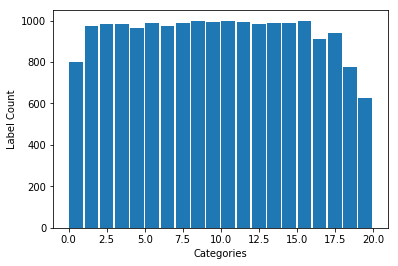

20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [77]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

twenty_data20 = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
x = range(-1,23)
plt.hist(twenty_data20.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xlim(xmin=-1, xmax = 21)
plt.savefig('{}/20-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

category_labels = twenty_data20.target
categories = twenty_data20.target_names
print(len(categories)) # there should be 20
print(categories)

##### Redo CountVect and TF-IDF calculations

In [78]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect20 = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data20 = count_vect20.fit_transform(twenty_data20.data)

In [79]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer20 = TfidfTransformer()

# do for training
X_data_tfidf20 = tfidf_transformer20.fit_transform(X_data20)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf20.shape))

Dimensions of the TF-IDF matrix are: (18846, 52295)


##### Applying K-means

In [80]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans
import time

k_name20 = 'kmeans_raw20'

kmeans20 = load_kmeans(k_name20)
start_time = time.time()
if kmeans20 is None:
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init = 40, n_jobs=-1).fit(X_data_tfidf20)
    dump_kmeans(k_name20, kmeans20)
print('Time taken for kmean 20-class clustering: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class clustering: 0.00 minutes


#### Report the 5 measures:

In [81]:
scores(category_labels, kmeans20)

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3594
Completeness: 0.4511
V-measure: 0.4001
Adjusted Rand Index: 0.1366
Adjusted Mutual Information Score: 0.3573
-------------------------------------------------------------------


##### and the contingency matrix:

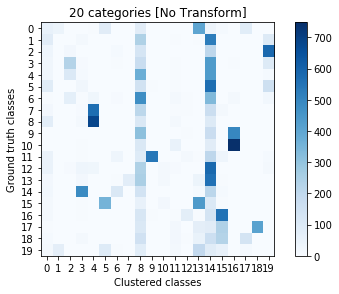

In [82]:
# Contingency matrix
show_contingency(category_labels, kmeans20.labels_, title='20 categories [No Transform]', hide_text=True)

#### Question 12

##### Analyzing SVD:

In [97]:
# Initialize r, which is basically how many components we want to use.
r20 = [1, 2, 3, 5, 10, 20, 50, 100, 300, 1000]

def show_best(model_type, scores):
    best = r20[np.argmax(scores)]
    print('best {}:'.format(model_type), best, np.round(np.amax(scores), 4))
    return best

svd_homogeneity = np.zeros(len(r20))
svd_completeness = np.zeros(len(r20))
svd_v = np.zeros(len(r20))
svd_rand = np.zeros(len(r20))
svd_mutual_info = np.zeros(len(r20))

nmf_homogeneity = np.zeros(len(r20))
nmf_completeness = np.zeros(len(r20))
nmf_v = np.zeros(len(r20))
nmf_rand = np.zeros(len(r20))
nmf_mutual_info = np.zeros(len(r20))

In [98]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd20 = TruncatedSVD(n_components=r20[-1])
X_data_svd_r20 = svd20.fit_transform(X_data_tfidf20)

In [99]:
import time
start_time = time.time()

npz_name = 'svd20'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_svd_r20[:, 0:r20[i]])
        svd_homogeneity[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity,
        'completeness': svd_completeness,
        'v': svd_v,
        'rand': svd_rand,
        'mutual_info': svd_mutual_info
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity = data['homogeneity']
    svd_completeness = data['completeness']
    svd_v = data['v']
    svd_rand = data['rand']
    svd_mutual_info = data['mutual_info']
    
print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.19 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.48 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.50 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.48 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.36 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.26 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 0.39 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 0.57 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=300: 1.53 minutes
r=1000: 4.28 minutes
Time taken for kmean 20-class SVD search: 9.04 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


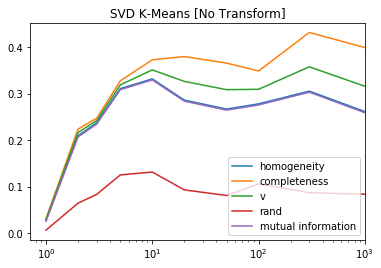

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0281 0.2096 0.2374 0.3112 0.3323 0.2865 0.2672 0.2784 0.3059 0.2617]
Completeness: [0.0311 0.2239 0.2475 0.3281 0.3735 0.3804 0.3663 0.3494 0.4325 0.3998]
V-measure: [0.0295 0.2165 0.2424 0.3194 0.3517 0.3269 0.309  0.3099 0.3583 0.3164]
Adjusted Rand Index: [0.006  0.0641 0.0831 0.1251 0.1313 0.0928 0.0807 0.1059 0.0867 0.0836]
Adjusted Mutual Information Score: [0.0249 0.207  0.235  0.309  0.3301 0.2842 0.2648 0.276  0.3036 0.2593]
-------------------------------------------------------------------


In [100]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity)
plt.plot(r20, svd_completeness)
plt.plot(r20, svd_v)
plt.plot(r20, svd_rand)
plt.plot(r20, svd_mutual_info)

plt.title('SVD K-Means [No Transform]')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

##### Analyzing NMF:

In [101]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [102]:
# Perform NMF for each number of components and calculate each metric

import time
start_time = time.time()

npz_name = 'nmf20'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_nmf_r)
        nmf_homogeneity[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity,
        'completeness': nmf_completeness,
        'v': nmf_v,
        'rand': nmf_rand,
        'mutual_info': nmf_mutual_info
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity = data['homogeneity']
    nmf_completeness = data['completeness']
    nmf_v = data['v']
    nmf_rand = data['rand']
    nmf_mutual_info = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.20 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.36 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.43 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.45 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.36 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.28 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 1.16 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 1.92 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=300: 27.10 minutes
r=1000: 118.24 minutes
Time taken for kmean 20-class NMF search: 150.50 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


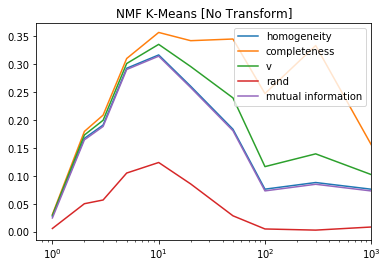

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0281 0.1674 0.1913 0.2929 0.3167 0.2607 0.1837 0.0764 0.0883 0.0763]
Completeness: [0.0311 0.1798 0.209  0.3103 0.357  0.3423 0.3452 0.2475 0.3336 0.156 ]
V-measure: [0.0295 0.1734 0.1998 0.3014 0.3357 0.296  0.2398 0.1168 0.1396 0.1025]
Adjusted Rand Index: [0.006  0.0504 0.057  0.1053 0.1242 0.0858 0.0287 0.0051 0.0031 0.0086]
Adjusted Mutual Information Score: [0.0249 0.1647 0.1887 0.2906 0.3145 0.2583 0.181  0.0733 0.0852 0.0732]
-------------------------------------------------------------------


In [103]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity)
plt.plot(r20, nmf_completeness)
plt.plot(r20, nmf_v)
plt.plot(r20, nmf_rand)
plt.plot(r20, nmf_mutual_info)

plt.title('NMF K-Means [No Transform]')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

##### Choosing best r for SVD and NMF

In [104]:
best_r_svd = show_best('svd', svd_rand)
best_r_nmf = show_best('nmf', nmf_rand)

best svd: 10 0.1313
best nmf: 10 0.1242


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3323
Completeness: 0.3735
V-measure: 0.3517
Adjusted Rand Index: 0.1313
Adjusted Mutual Information Score: 0.3301
-------------------------------------------------------------------


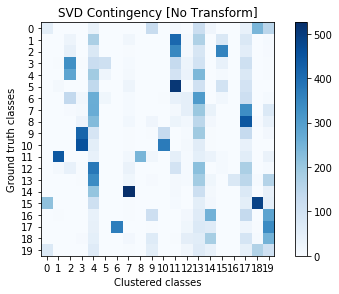

In [105]:
k_name = 'kmeans20_best_svd'
kmeans = load_kmeans(k_name)
if kmeans is None:
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_svd_r20[:, 0:best_r_svd])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Contingency [No Transform]', hide_text=True)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3089
Completeness: 0.3438
V-measure: 0.3254
Adjusted Rand Index: 0.119
Adjusted Mutual Information Score: 0.3066
-------------------------------------------------------------------


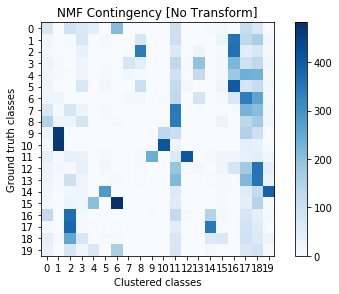

In [106]:
k_name = 'kmeans20_best_nmf'
kmeans = load_kmeans(k_name)
if kmeans is None:
    nmf = NMF(n_components=best_r_nmf)
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_nmf_r)
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='NMF Contingency [No Transform]', hide_text=True)

##### Perform Scaling Transform and attain new graphs

In [107]:
# Perform SVD

svd_uv_transform20 = scaling(X_data_svd_r20)

svd_homogeneity_uv = np.zeros(len(r20))
svd_completeness_uv = np.zeros(len(r20))
svd_v_uv = np.zeros(len(r20))
svd_rand_uv = np.zeros(len(r20))
svd_mutual_info_uv = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_transform20[:, 0:r20[i]])
        svd_homogeneity_uv[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_uv[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_uv[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_uv[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_uv[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_uv,
        'completeness': svd_completeness_uv,
        'v': svd_v_uv,
        'rand': svd_rand_uv,
        'mutual_info': svd_mutual_info_uv
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_uv = data['homogeneity']
    svd_completeness_uv = data['completeness']
    svd_v_uv = data['v']
    svd_rand_uv = data['rand']
    svd_mutual_info_uv = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.19 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.40 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.47 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.46 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.27 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.22 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 0.44 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 0.57 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=300: 1.31 minutes
r=1000: 3.49 minutes
Time taken for kmean 20-class SVD search: 7.82 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


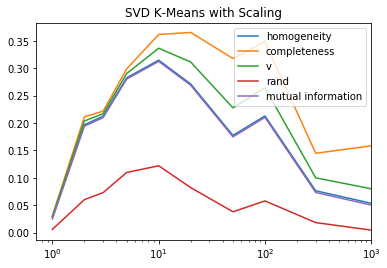

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0281 0.1968 0.2125 0.2826 0.3148 0.2714 0.1775 0.213  0.0764 0.0536]
Completeness: [0.0311 0.2114 0.2218 0.299  0.3618 0.3655 0.3179 0.3487 0.145  0.1585]
V-measure: [0.0295 0.2039 0.217  0.2906 0.3367 0.3115 0.2278 0.2645 0.1001 0.0801]
Adjusted Rand Index: [0.006  0.0603 0.0731 0.1099 0.1221 0.0823 0.0381 0.0579 0.0184 0.0046]
Adjusted Mutual Information Score: [0.0249 0.1942 0.21   0.2803 0.3126 0.2691 0.1748 0.2104 0.0733 0.0503]
-------------------------------------------------------------------


In [108]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_uv)
plt.plot(r20, svd_completeness_uv)
plt.plot(r20, svd_v_uv)
plt.plot(r20, svd_rand_uv)
plt.plot(r20, svd_mutual_info_uv)

plt.title('SVD K-Means with Scaling')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [109]:
# Perform NMF

nmf_homogeneity_uv = np.zeros(len(r20))
nmf_completeness_uv = np.zeros(len(r20))
nmf_v_uv = np.zeros(len(r20))
nmf_rand_uv = np.zeros(len(r20))
nmf_mutual_info_uv = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_uv_transform20 = scaling(X_data_nmf_r20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_transform20)
        nmf_homogeneity_uv[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_uv[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_uv[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_uv[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_uv[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_uv,
        'completeness': nmf_completeness_uv,
        'v': nmf_v_uv,
        'rand': nmf_rand_uv,
        'mutual_info': nmf_mutual_info_uv
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_uv = data['homogeneity']
    nmf_completeness_uv = data['completeness']
    nmf_v_uv = data['v']
    nmf_rand_uv = data['rand']
    nmf_mutual_info_uv = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.20 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.42 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.47 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.46 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.33 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.28 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 1.19 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 3.70 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=300: 15.60 minutes
r=1000: 108.00 minutes
Time taken for kmean 20-class NMF search: 130.65 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


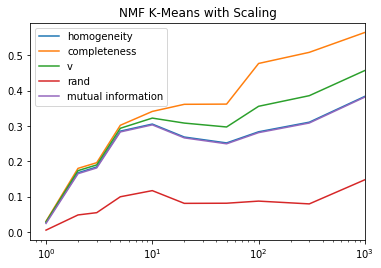

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0281 0.1681 0.1843 0.2856 0.3056 0.2689 0.2523 0.2838 0.3109 0.3838]
Completeness: [0.0311 0.1805 0.1964 0.3021 0.3413 0.3614 0.3619 0.4767 0.5082 0.5644]
V-measure: [0.0295 0.1741 0.1902 0.2936 0.3224 0.3084 0.2973 0.3558 0.3858 0.4569]
Adjusted Rand Index: [0.006  0.0489 0.0553 0.1002 0.1176 0.0816 0.082  0.088  0.0801 0.1483]
Adjusted Mutual Information Score: [0.0249 0.1654 0.1817 0.2833 0.3033 0.2665 0.2498 0.2814 0.3086 0.3818]
-------------------------------------------------------------------


In [110]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_uv)
plt.plot(r20, nmf_completeness_uv)
plt.plot(r20, nmf_v_uv)
plt.plot(r20, nmf_rand_uv)
plt.plot(r20, nmf_mutual_info_uv)

plt.title('NMF K-Means with Scaling')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [111]:
best_r_svd_uv = show_best('svd uv', svd_rand_uv)
best_r_nmf_uv = show_best('nmf uv', nmf_rand_uv[:-1])

best svd uv: 10 0.1221
best nmf uv: 10 0.1176


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3148
Completeness: 0.3618
V-measure: 0.3367
Adjusted Rand Index: 0.1221
Adjusted Mutual Information Score: 0.3126
-------------------------------------------------------------------


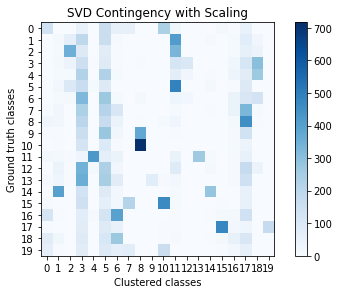

In [112]:
k_name = 'kmeans20_best_svd_uv'
kmeans = load_kmeans(k_name)
if kmeans is None:
    svd_uv_transform20 = scaling(X_data_svd_r20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_transform20[:, 0:best_r_svd_uv])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Contingency with Scaling', hide_text=True)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3056
Completeness: 0.3413
V-measure: 0.3224
Adjusted Rand Index: 0.1176
Adjusted Mutual Information Score: 0.3033
-------------------------------------------------------------------


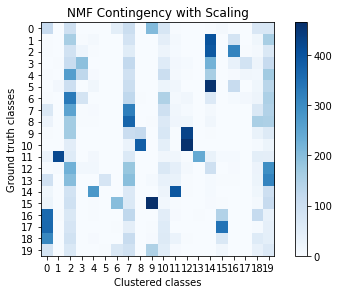

In [113]:
k_name = 'kmeans20_best_nmf_uv'
kmeans = load_kmeans(k_name)
if kmeans is None:
    nmf = NMF(n_components=best_r_nmf_uv)
    X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
    nmf_uv_transform20 = scaling(X_data_nmf_r20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_transform20)
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='NMF Contingency with Scaling', hide_text=True)

##### Perform Log Transform and attain new graphs

In [114]:
# Perform SVD

svd_log_transform20 = logarithm_trans(X_data_svd_r20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.18 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.34 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.44 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.37 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.37 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.25 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 0.40 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 0.62 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=300: 1.52 minutes
r=1000: 5.48 minutes
Time taken for kmean 20-class SVD search: 9.95 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


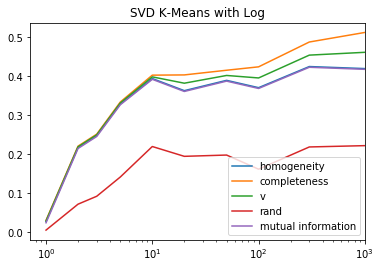

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0277 0.2173 0.248  0.329  0.394  0.363  0.3894 0.3706 0.4247 0.4195]
Completeness: [0.0309 0.2208 0.2515 0.3339 0.4027 0.4033 0.4153 0.424  0.4876 0.5121]
V-measure: [0.0292 0.219  0.2498 0.3314 0.3983 0.3821 0.4019 0.3955 0.454  0.4612]
Adjusted Rand Index: [0.0057 0.0722 0.0924 0.1418 0.2199 0.1947 0.198  0.1618 0.2188 0.2221]
Adjusted Mutual Information Score: [0.0245 0.2148 0.2456 0.3268 0.392  0.3609 0.3874 0.3686 0.4229 0.4176]
-------------------------------------------------------------------


In [115]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Log')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [121]:
# Resetting r20
r20 = [1, 2, 3, 5, 10, 20, 50, 100, 300]

def show_best(model_type, scores):
    best = r20[np.argmax(scores)]
    print('best {}:'.format(model_type), best, np.round(np.amax(scores), 4))
    return best

In [122]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


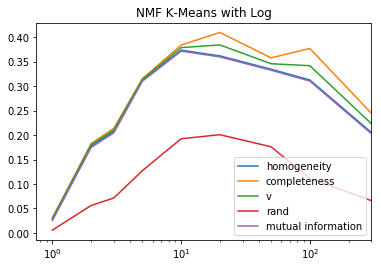

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0283 0.1773 0.207  0.312  0.3735 0.3617 0.3345 0.3125 0.2055]
Completeness: [0.0309 0.1826 0.2137 0.3152 0.3838 0.4097 0.3578 0.3769 0.2447]
V-measure: [0.0295 0.1799 0.2103 0.3136 0.3786 0.3842 0.3458 0.3417 0.2234]
Adjusted Rand Index: [0.0057 0.0561 0.0713 0.1272 0.1924 0.2007 0.176  0.1112 0.066 ]
Adjusted Mutual Information Score: [0.0251 0.1746 0.2044 0.3098 0.3714 0.3597 0.3324 0.3103 0.2029]
-------------------------------------------------------------------


In [123]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Log')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

#### Choose best r for transformation

In [125]:
svd_log_r20_best = show_best('svd log', svd_rand_log[:-1])
nmf_log_r20_best = show_best('nmf log', nmf_rand_log)

best svd log: 10 0.2199
best nmf log: 20 0.2007


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.394
Completeness: 0.4027
V-measure: 0.3983
Adjusted Rand Index: 0.2199
Adjusted Mutual Information Score: 0.392
-------------------------------------------------------------------


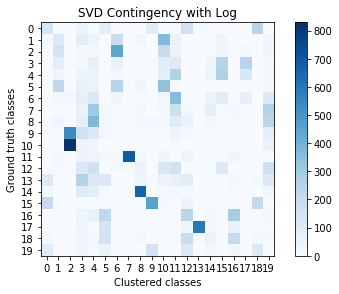

In [126]:
k_name = 'kmeans20_best_svd_log'
kmeans = load_kmeans(k_name)
if kmeans is None:
    svd_log_transform20 = logarithm_trans(X_data_svd_r20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_transform20[:, 0:svd_log_r20_best])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Contingency with Log', hide_text=True)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3606
Completeness: 0.4002
V-measure: 0.3794
Adjusted Rand Index: 0.1945
Adjusted Mutual Information Score: 0.3586
-------------------------------------------------------------------


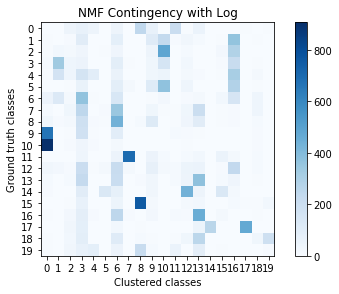

In [127]:
k_name = 'kmeans20_best_nmf_log'
kmeans = load_kmeans(k_name)
if kmeans is None:
    nmf = NMF(n_components=nmf_log_r20_best)
    X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
    nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_transform20)
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='NMF Contingency with Log', hide_text=True)

##### Perform  Log -> Scaling Transform and attain new graphs

In [128]:
# Perform SVD

svd_log_transform20 = logarithm_trans(X_data_svd_r20)
svd_log_scaling_transform20 = scaling(svd_log_transform20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_log_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_scaling_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.18 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.37 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.39 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.31 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.30 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.23 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 0.42 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 0.73 minutes
r=300: 1.99 minutes
Time taken for kmean 20-class SVD search: 4.93 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


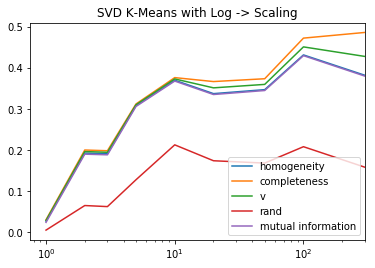

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0277 0.1927 0.1911 0.3081 0.3696 0.337  0.3467 0.431  0.3816]
Completeness: [0.0309 0.2002 0.1984 0.312  0.3759 0.3663 0.3732 0.4718 0.4856]
V-measure: [0.0292 0.1964 0.1947 0.31   0.3727 0.3511 0.3595 0.4505 0.4273]
Adjusted Rand Index: [0.0057 0.0654 0.0628 0.128  0.2127 0.1741 0.1684 0.2082 0.1584]
Adjusted Mutual Information Score: [0.0245 0.1901 0.1885 0.3059 0.3675 0.3349 0.3446 0.4292 0.3796]
-------------------------------------------------------------------


In [129]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Log -> Scaling')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [130]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_log_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
        nmf_log_scaling_transform20 = scaling(nmf_log_transform20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_scaling_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.18 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.42 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.48 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.46 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.41 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.37 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 1.95 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 4.55 minutes
r=300: 17.41 minutes
Time taken for kmean 20-class NMF search: 26.23 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


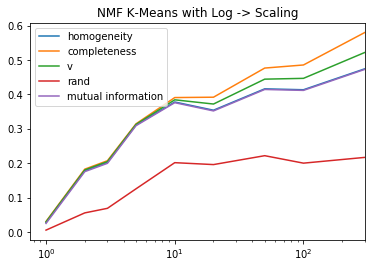

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0283 0.1782 0.2023 0.3111 0.3778 0.354  0.4161 0.4134 0.4744]
Completeness: [0.0309 0.1828 0.2073 0.3144 0.3907 0.3917 0.4764 0.4854 0.5799]
V-measure: [0.0295 0.1804 0.2048 0.3128 0.3842 0.3719 0.4442 0.4465 0.5218]
Adjusted Rand Index: [0.0057 0.0557 0.069  0.1256 0.2016 0.196  0.2219 0.2002 0.217 ]
Adjusted Mutual Information Score: [0.0251 0.1755 0.1997 0.3089 0.3758 0.3519 0.4142 0.4115 0.4726]
-------------------------------------------------------------------


In [131]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Log -> Scaling')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [132]:
svd_best_r_log_uv = show_best('svd log', svd_rand_log)
nmf_best_r_log_uv = show_best('nmf log', nmf_rand_log)

best svd log: 10 0.2127
best nmf log: 50 0.2219


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3696
Completeness: 0.3759
V-measure: 0.3727
Adjusted Rand Index: 0.2127
Adjusted Mutual Information Score: 0.3675
-------------------------------------------------------------------


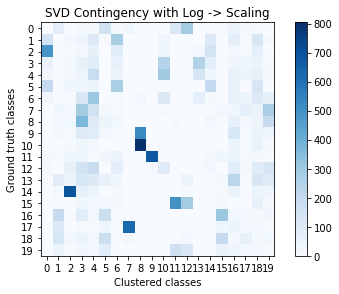

In [133]:
k_name = 'kmeans20_best_svd_log_uv'
kmeans = load_kmeans(k_name)
if kmeans is None:
    svd_log_transform20 = logarithm_trans(X_data_svd_r20)
    svd_log_scaling_transform20 = scaling(svd_log_transform20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_scaling_transform20[:, 0:svd_best_r_log_uv])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Contingency with Log -> Scaling', hide_text=True)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3968
Completeness: 0.4759
V-measure: 0.4328
Adjusted Rand Index: 0.1934
Adjusted Mutual Information Score: 0.3949
-------------------------------------------------------------------


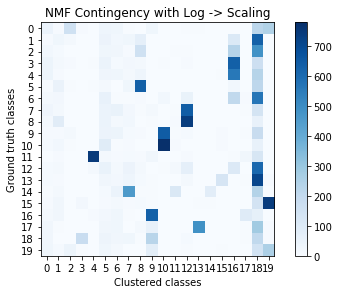

In [134]:
k_name = 'kmeans20_best_nmf_log_uv'
kmeans = load_kmeans(k_name)
if kmeans is None:
    nmf = NMF(n_components=nmf_best_r_log_uv)
    X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
    nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
    nmf_log_scaling_transform20 = scaling(nmf_log_transform20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_scaling_transform20)
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='NMF Contingency with Log -> Scaling', hide_text=True)

##### Perform  Scaling -> Log Transform and attain new graphs

In [135]:
# Perform SVD

svd_scaling_transform20 = scaling(X_data_svd_r20)
svd_uv_log_transform20 = logarithm_trans(svd_scaling_transform20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_uv_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_log_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.12 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.24 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.22 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.10 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.29 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.28 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 0.42 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 0.73 minutes
r=300: 2.42 minutes
Time taken for kmean 20-class SVD search: 4.83 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


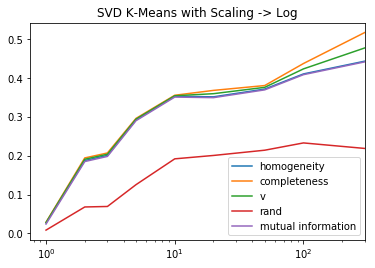

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0272 0.1875 0.2006 0.2922 0.3527 0.3513 0.3712 0.4102 0.4431]
Completeness: [0.0288 0.1942 0.2069 0.2958 0.3553 0.3678 0.3803 0.4369 0.5169]
V-measure: [0.028  0.1908 0.2037 0.294  0.354  0.3594 0.3757 0.4231 0.4771]
Adjusted Rand Index: [0.0085 0.068  0.0693 0.1254 0.1918 0.2005 0.214  0.2327 0.2185]
Adjusted Mutual Information Score: [0.0241 0.1848 0.198  0.2899 0.3506 0.3492 0.3692 0.4083 0.4412]
-------------------------------------------------------------------


In [136]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Scaling -> Log')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [137]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_uv_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_scaling_transform20 = scaling(X_data_nmf_r20)
        nmf_uv_log_transform20 = logarithm_trans(nmf_scaling_transform20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_log_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=1: 0.13 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=2: 0.25 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=3: 0.26 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=5: 0.20 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=10: 0.30 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=20: 0.39 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=50: 1.40 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


r=100: 3.74 minutes
r=300: 27.85 minutes
Time taken for kmean 20-class NMF search: 34.52 minutes


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


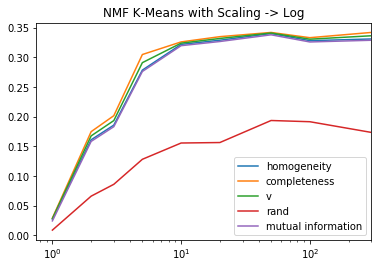

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0272 0.1608 0.1856 0.2784 0.3218 0.3288 0.3401 0.328  0.3309]
Completeness: [0.0288 0.1746 0.2015 0.3047 0.326  0.3348 0.3419 0.3331 0.3419]
V-measure: [0.028  0.1674 0.1932 0.2909 0.3239 0.3318 0.341  0.3305 0.3363]
Adjusted Rand Index: [0.0085 0.0658 0.0858 0.128  0.1554 0.1562 0.1934 0.1913 0.1733]
Adjusted Mutual Information Score: [0.0241 0.1581 0.183  0.2761 0.3196 0.3266 0.3379 0.3259 0.3287]
-------------------------------------------------------------------


In [138]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Scaling -> Log')
plt.xscale('log')
plt.xlim(right=r20[-1])
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [139]:
svd_best_r_uv_log = show_best('svd uv log', svd_rand_log)
nmf_best_r_uv_log = show_best('nmf uv log', nmf_rand_log)

best svd uv log: 100 0.2327
best nmf uv log: 50 0.1934


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.4102
Completeness: 0.4369
V-measure: 0.4231
Adjusted Rand Index: 0.2327
Adjusted Mutual Information Score: 0.4083
-------------------------------------------------------------------


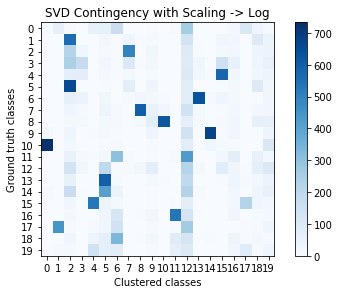

In [140]:
k_name = 'kmeans20_best_svd_uv_log'
kmeans = load_kmeans(k_name)
if kmeans is None:
    svd_scaling_transform20 = scaling(X_data_svd_r20)
    svd_uv_log_transform20 = logarithm_trans(svd_scaling_transform20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_log_transform20[:, 0:svd_best_r_uv_log])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Contingency with Scaling -> Log', hide_text=True)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3056
Completeness: 0.3084
V-measure: 0.307
Adjusted Rand Index: 0.1556
Adjusted Mutual Information Score: 0.3034
-------------------------------------------------------------------


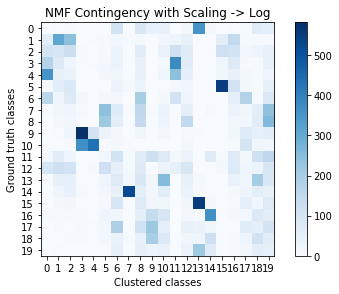

In [141]:
k_name = 'kmeans20_best_nmf_uv_log'
kmeans = load_kmeans(k_name)
if kmeans is None:
    nmf = NMF(n_components=nmf_best_r_uv_log)
    X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
    nmf_scaling_transform20 = scaling(X_data_nmf_r20)
    nmf_uv_log_transform20 = logarithm_trans(nmf_scaling_transform20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_log_transform20)
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='NMF Contingency with Scaling -> Log', hide_text=True)

##### Example of undesirable outcome: Scaled SVD with r=300

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.0764
Completeness: 0.145
V-measure: 0.1001
Adjusted Rand Index: 0.0184
Adjusted Mutual Information Score: 0.0733
-------------------------------------------------------------------


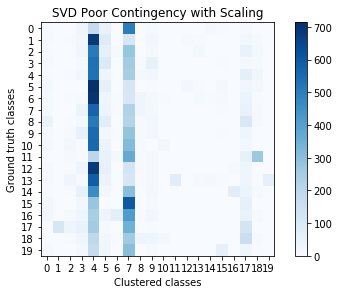

In [142]:
k_name = 'kmeans20_worst_svd_uv'
kmeans = load_kmeans(k_name)
if kmeans is None:
    svd_uv_transform20 = scaling(X_data_svd_r20)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_transform20[:, 0:300])
    dump_kmeans(k_name, kmeans)

scores(category_labels, kmeans)
show_contingency(category_labels, kmeans.labels_, title='SVD Poor Contingency with Scaling', hide_text=True)